# Information Retrieval and Web Analytics

# Recommender Systems - A practical overview

Today we're going to work with different algorithms common in Recommender Systems such as memory based and model based Collaborative Filtering, accuracy of similarity functions, and popularity bias.

We will:

1. Play with user-user and item-item *Memory Based Collaborative Filtering* (CF) models, testing and comparing the two, to see which one gives the best performance.

2. Test different *similarity functions* to see which one gives the highest accuracy.

3. Play with *Model Based Matrix Factorization* (CF) algorithm, comparing its performance with the models seen before.

4. Check for *Popularity Bias* in the output.

Let's get into it.

# 1. Memory Based Collaborative Filtering

**How it works**
Collaborative Filtering recommender systems are among the most prominent approaches to generate recommendations. They are popular and well-studied in academia but also widely used by industry, like commercial e-commerce sites. They are based on the concept of **wisdom of the crowd**, where predictions are generated looking at patterns of similarity in the data. The crucial assumption is *customers who had similar tastes in the past, will have similar tastes in the future*.

**Item-based and User-based**
Similarities are extracted in two different ways, looking either at user-user interactions or at item-item interactions.

cf.png

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# first of all we load the data and rename columns
df_ratings = pd.read_csv("data/ratings.dat", sep="::", header = None)
df_ratings.columns = ["UserID","MovieID", "Rating", "Timestamp"]

In [ ]:
# we split the dataset in train and test, keeping the 90% as the training set, and the rest as test set
df_test = df_ratings.sample(frac=0.1, random_state=123)
df_train = df_ratings[df_ratings.index.isin(df_test.index) == False]

In [ ]:
# we extract the max-id for users and items
n_users = max(df_ratings["UserID"].unique())+1
m_items = max(df_ratings["MovieID"].unique())+1

We then generate the sparse matrix of interactions $M$, where each value $m_{ui}$ corresponds to the rating of the user *u* for the movie *i*.

**Why sparse matrix?**
To handle huge matrices and avoid using memory for zero-entries, we can exploit a sparse data structure.  
If most of the elements are nonzero, then the matrix is considered *dense*. The number of zero-valued elements divided by the total number of elements (e.g., m × n for an m × n matrix) is sometimes referred to as the **sparsity** of the matrix.

In [ ]:
def get_sparse_matrix(interactions, weights, n_users, m_items):
    interactions = list(zip(*interactions))
    adjacency_matrix = csr_matrix((weights, interactions), shape = (n_users,m_items))
    return adjacency_matrix

In [ ]:
lst_interactions = df_train[["UserID", "MovieID"]].values
ratings = df_train["Rating"]

# generate sparse matrix of ratings
M = get_sparse_matrix(lst_interactions, ratings, n_users, m_items)

We then use the **cosine similarity** score to generate the user-user and item-item pair-wise similarity values.

In [ ]:
# user-user similarity
user_user_sim = cosine_similarity(M)

# item-item similarity
item_item_sim = cosine_similarity(M.T)

In [ ]:
def get_baseline_score(M, user_id, item_id):
    """
    it computes the baseline score b_ui = \mu + b_i + b_u
    \mu = avg. score given by the dataset
    b_i = avg. score given by all the users to the item i
    b_u = avg. score given by the user u to all the rated elements
    """

    mean_ = ### your code ###

    b_i = ### your code ###
    b_u = ### your code ###

    out = mean_ + b_i + b_u
    return out

In [ ]:
def predict_item_item(similarity_M, b_ui, user_id, item_id, k = 10):
    """
    here we compute the final score based on item-item CF model
    \hat{r}_{ui} = \frac{\sum_{j \in N_k} s(i,j) (r_{uj} - b_{uj}) } {\sum_{j \in N_k} s(i,j)}
    to choose the k to get the N_k we just order the idx and select the first k idxs
    """
    # similar items
    # here extract the idxs of the items which are similar to the selected *item-id*
    similar_items_idx = ### your code ###

    # rated items - here we take the column-indexes
    # here we extract the idxs of the items rated by the selected user-id
    rated_by_user_idx = ### your code ###

    # rated and similar items
    # here we find the intersection between the two sets, rated_by_user and similar_items
    rated_and_similar = set(similar_items_idx).intersection(rated_by_user_idx)

    # we then consider for our task the first k idxs (ordered by id, *NOT* by score)
    rated_and_similar = sorted(rated_and_similar)[:k]

    out = 0
    den = 0

    for item_sim_and_rated in rated_and_similar:

        # baseline score for item_sim_and_rated and user_id
        one_b_ui = get_baseline_score(### your code ###)

        # similarity between item_sim_and_rated and item_id
        s_ij = similarity_M[### your code ###]

        # difference between rating given by the user_id to item_sim_and_rated AND one_b_ui
        diff_ = M[### your code ###] - ### your code ###

        # update num
        out+= s_ij*diff_

        # update den
        den += s_ij

    # compute ratio
    out = out/den

    # add b_ui
    out = b_ui + out
    return out

In [ ]:
def predict_user_user(similarity_M, b_ui, user_id, item_id, k = 10):

    """
    here we compute the final score based on item-item CF model
    \hat{r}_{ui} = \frac{\sum_{v \in N_k} s(u,v) (r_{vi} - b_{vi}) } {\sum_{v \in N_k} s(u,v)}
    to choose the k to get the N_k we just order the idx and select the first k idxs
    """
    # similar users
    similar_users_idx = ### your code ###
    # indexes of the user that rated this item
    # rated items - here we take the row-indexes
    same_item_rated = ### your code ###

    # rated and similar items
    rated_same_and_similar = ### your code ###

    # take the first k
    rated_same_and_similar = ### your code ###

    out = 0
    den = 0

    for user_same_and_similar in rated_same_and_similar:

        # baseline score for item_sim_and_rated and user_id
        one_b_ui = ### your code ###

        # similarity between user_id and user_same_and_similar
        s_ij = ### your code ###

        # difference between rating given gy user_same_and_similar AND one_b_ui
        diff_ = ### your code ###

        out+= s_ij*diff_

        den += s_ij

    out = out/den
    out = b_ui + out
    return out

In [ ]:
df_test.head()

In [ ]:
# compute the estimate with the two approaches
user_id = 2233
item_id = 440
b_ui = get_baseline_score(M, user_id, item_id)

prediction_item_item = predict_item_item(item_item_sim, b_ui, user_id, item_id)
prediction_user_user = predict_user_user(user_user_sim, b_ui, user_id, item_id)

Test the score estimation for one tuple (uid, iid)

In [ ]:
prediction_item_item, prediction_user_user

(3.7511541341110797, 3.4264185601314714)

# 2. Comparison with difference similarity functions

Here we test the two models presented before with two different functions of similarity. We use *Cosine Similarity* and *Pearson Coefficient* with the item-item approach, testing the results over the first 20 ratings.

For the evaluation we use the *Root Mean Square Error (RMSE)*:

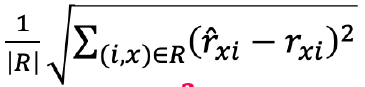

In [ ]:
# user-user similarity
user_user_sim2 = np.corrcoef(M.toarray())

# item-item similarity
item_item_sim2 = np.corrcoef(M.toarray().T)

Compare RMSE between the 4 models - compute the rating for the first 10 obs of the test, then compute the RMSE

In [ ]:
def compute_RMSE(list_of_tuples_r_ui_r_ui_hat):
    """
    sqrt(\sum (r_ui - r_ui_hat)^2 )
    """

    # here we have the (r_{ui} - \hat r_{ui})**2
    diff_ = [### your code ### for (r_ui, r_ui_hat) in list_of_tuples_r_ui_r_ui_hat]

    # we then sum the vector of squared differences
    out = ### your code ###

    # and then apply the square-root
    out = ### your code ###

    # we then divide the final value by the length of the vector - to get an avg. estimate
    out = ### your code ###
    return out

In [ ]:
# performance over the top-20 ratings of the test-set

r_ui_r_ui_hat_1 = []
r_ui_r_ui_hat_2 = []

for user_id, item_id, rating in df_test.head(20)[["UserID", "MovieID", "Rating"]].values:

    # compute first the baseline score
    b_ui = get_baseline_score(M, user_id, item_id)

    # prediction with cosine similarity
    prediction_item_item1 = predict_item_item(item_item_sim, b_ui, user_id, item_id)
    r_ui_r_ui_hat_1.append((prediction_item_item1, rating))

    # prediction with pearson correlation
    prediction_item_item2 = predict_item_item(item_item_sim2, b_ui, user_id, item_id)
    r_ui_r_ui_hat_2.append((prediction_item_item2, rating))

In [ ]:
compute_RMSE(r_ui_r_ui_hat_1), compute_RMSE(r_ui_r_ui_hat_2)

(0.1680177565497746, 0.17166301445439586)

# 3. Model Based Collaborative Filtering

**Matrix Factorization**
Matrix factorization models generate low dimensional latent features, for both users and items, in order to catch the relationship between items’ and users’ with respect to the whole dataset.


**Library used here**

*Surprise* is a Python `scikit` library for building and analyzing Recommender Systems that deal with explicit rating data. It provides tools to evaluate, analyze and compare the algorithms’ performance.

[Link](http://surpriselib.com/) to the library.

We now compare the performances of the previous models and 2 other matrix factorization algorithms (SVD and NMF)

In [ ]:
from surprise import SVD
from surprise import KNNBaseline
from surprise import NMF
from surprise.model_selection import train_test_split
from surprise import Dataset
from surprise import Reader

In [ ]:
# use surprise functions
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_ratings[["UserID", "MovieID", "Rating"]], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=123)

In [ ]:
## svd model
svd_model = SVD(n_factors=10, n_epochs=10)
svd_model.fit(trainset)

In [ ]:
## non-negative matrix factorization
nmf_model = NMF(n_factors=15, n_epochs=10)
nmf_model.fit(trainset)

In [ ]:
## user-user CF
user_user_CF = KNNBaseline(k=5, sim_options={'user_based': True, 'name': 'pearson_baseline'})
user_user_CF.fit(trainset)

In [ ]:
## item-item CF
item_item_CF = KNNBaseline(k=5, sim_options={'user_based': False, 'name': 'pearson_baseline'})
item_item_CF.fit(trainset)

In [ ]:
# we then test the models and check which gives best performances
main_df = pd.DataFrame(columns=["Model", "RMSE"])

for label, model in [("svd", svd_model), ("NMF",nmf_model), ("UserUser", user_user_CF), ("ItemItem",item_item_CF)]:
    predictions_ = model.test(testset)

    # we then extract only the items in position 2 and 3, which are the rating and its estimate
    only_scores = ### your code ###
    one_rmse = ### your code ###

    main_df.loc[len(main_df)] = ### your code ###

In [ ]:
model.test(testset)

In [ ]:
# we check here the final result
main_df

# 4. Popularity Bias

Recommender Systems are known to suffer from the *popularity bias problem*: popular (i.e. frequently rated) items get a lot of exposure while less popular ones are under-represented when generating the recommendations. Here **we analyze the popularity-bias stimulated by the matrix factorization algorithm, analyzing the frequency of items distribution given by recommendation lists** generated for the first 100 users.

In [ ]:
def get_top_n(predictions, n=10):

    """Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = {}
    for uid, iid, true_r, est, _ in predictions:
        # check if user not in the top_n
        ### your code ###
            ### your code ###
        # then add the tuple (iid, est)
        ### your code ###

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        # sort by the user-rating the list
        ### your code ###
        # take only the top-n ratings
        ### your code ###

        # take only the iid and not the rating from each tuple
        top_n[uid] = ### your code ###

    return top_n

We first extract all the missing ratings for the first 100 users

In [ ]:
missing_ratings = set()
all_items = set(trainset.all_items())
for uid in range(100):
    known_ratings = set([x for x,y in trainset.ur[uid]])
    ### your code ###
        ### your code ###
            missing_ratings.add((uid, iid))

Then we generate the prediction with the SVD model

In [ ]:
new_predictions = []
for uid, iid in missing_ratings:
    new_predictions.append(svd_model.predict(uid, iid))

Then we generate the top-n recommendations for each user, with n=10

In [ ]:
top_n = get_top_n(new_predictions)

In [ ]:
freq_items = {}
for uid in top_n:
    new_rec = top_n[uid]
    for iid in new_rec:
        ### your code ###
            ### your code ###
        ### your code ###

We then plot the distribution of the 100 most frequent items

In [ ]:
df_freq = pd.DataFrame.from_records(list(freq_items.items()))
df_freq.columns = ["item", "freq"]
df_freq.set_index("item", inplace=True)
df_freq.sort_values("freq", inplace=True)

In [ ]:
### your code ###
### your code ###
plt.show()